<a href="https://colab.research.google.com/github/amanbhal/data-science/blob/master/NYE_Stock_Exchange_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.core import Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

import time

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2


# load dataset
df = pd.read_csv("/content/drive/My Drive/ColabDatasets/NY_Stock_Market/prices-split-adjusted.csv") 

# select one company for data analysis
df = df[df['symbol']=='YHOO']

# drop unwanted columns
df = df.drop(['date', 'symbol','close', 'low', 'high', 'volume'], axis=1)

# feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# split data into test and train
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df[0:train_size,:], df[train_size:len(df),:]

In [0]:
# lookback 1 day in past
lookback = 2

def temporalize(X, lookback):
    output_X = []
    output_Y = []
    for i in range(len(X)-lookback-1):
        temp = X[i:(i+lookback), :]
        output_X.append(temp)
        output_Y.append(X[i+lookback, :])
    return np.array(output_X), np.array(output_Y)
  
X_train, y_train = temporalize(train,lookback)
X_test, y_test = temporalize(test,lookback)

# reshape the X_train and X_test for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], lookback, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], lookback, X_test.shape[2]))

In [47]:
# build the LSTM model

model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [48]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=20, validation_split=0.05)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 1335 samples, validate on 71 samples
Epoch 1/20
1335/1335 [==============================] - 3s 2ms/step - loss: 0.0996 - val_loss: 0.0913
Epoch 2/20
1335/1335 [==============================] - 0s 100us/step - loss: 0.0254 - val_loss: 0.0230
Epoch 3/20
1335/1335 [==============================] - 0s 98us/step - loss: 0.0103 - val_loss: 0.0028
Epoch 4/20
1335/1335 [==============================] - 0s 99us/step - loss: 0.0026 - val_loss: 7.5201e-04
Epoch 5/20
1335/1335 [==============================] - 0s 107us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/20
1335/1335 [==============================] - 0s 108us/step - loss: 0.0016 - val_loss: 7.6985e-04
Epoch 7/20
1335/1335 [==============================] - 0s 106us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 8/20
1335/1335 [==============================] - 0s 105us/step - loss: 0.0019 - val_loss: 4.8013e-04
Epoch 9/20
1335/1335 [==============================] - 0s 105us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 10/2

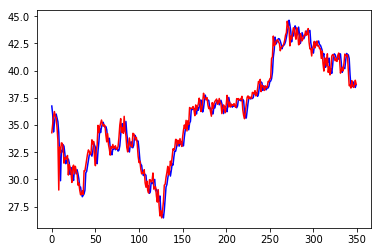

In [49]:
y_pred = model.predict(X_test)

plt.plot(scaler.inverse_transform(y_pred), 'b', label='predicted')
plt.plot(scaler.inverse_transform(y_test), 'r', label='actual')
plt.show()
